<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/03_nlp_project_main_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
path = "/content/drive/MyDrive/TwiBot-22_Processed"

lang_version = "/en"
embedding_version = "/v4"

In [2]:
#!pip install -q sentence-transformers

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.6f}".format)

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pyarrow.parquet as pq

enriched_user_features = pd.read_parquet(f"{path}{lang_version}/enriched_user_features.parquet", engine='pyarrow')

In [6]:
n_rows, n_columns = enriched_user_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 278227 rows and 58 columns.


In [7]:
n_features = enriched_user_features.shape[1]

numeric_cols = enriched_user_features.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = enriched_user_features.select_dtypes(include=['bool']).columns
text_cols = enriched_user_features.select_dtypes(include=['O']).columns

numeric_bool_cols = numeric_cols.append(bool_cols)

print(f"There are {n_features} features: {len(numeric_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 58 features: 43 numeric, 10 boolean, 5 text/object.


In [8]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_quotes,top_tweets_avg_replies,top_tweets_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,231954518,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,human,Great thread on building your startup. 40+ les...,[Great thread on building your startup. 40+ le...,0.200000,0.000000,0.400000,0.000000,0.000000,976.000000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,231807057,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,human,"RT <USER>: ""I spoke to President Putin this mo...","[RT <USER>: ""I spoke to President Putin this m...",0.000000,0.000000,0.900000,NaN,NaN,100.500000


In [9]:
# Check for missing values
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                        Missing Count  Missing Percentage
top_tweets_avg_quotes          165237           59.389276
top_tweets_avg_replies         165237           59.389276


In [10]:
enriched_user_features.dropna(axis=1, inplace=True)  # drop columns with any NaNs

In [11]:
# Check for missing values again
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [12]:
'''
# Check and handle duplicate rows
duplicates = enriched_user_features.duplicated().sum()
if duplicates > 0:
    print(f"Warning: The dataset contains {duplicates} duplicate rows.")
    enriched_user_features = enriched_user_features.drop_duplicates()
    print(f"\n{duplicates} duplicate rows have been dropped. The dataset now has {enriched_user_features.shape[0]} rows.")
else:
    print("No duplicate rows found in the dataset.")
'''

'\n# Check and handle duplicate rows\nduplicates = enriched_user_features.duplicated().sum()\nif duplicates > 0:\n    print(f"Warning: The dataset contains {duplicates} duplicate rows.")\n    enriched_user_features = enriched_user_features.drop_duplicates()\n    print(f"\n{duplicates} duplicate rows have been dropped. The dataset now has {enriched_user_features.shape[0]} rows.")\nelse:\n    print("No duplicate rows found in the dataset.")\n'

In [13]:
# Cast label column: 1 if "bot", 0 if "human"
enriched_user_features['label'] = enriched_user_features['label'].map({'human': 0, 'bot': 1})

In [14]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,231954518,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,0,Great thread on building your startup. 40+ les...,[Great thread on building your startup. 40+ le...,0.200000,0.000000,0.400000,976.000000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,231807057,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,0,"RT <USER>: ""I spoke to President Putin this mo...","[RT <USER>: ""I spoke to President Putin this m...",0.000000,0.000000,0.900000,100.500000


In [15]:
# Count human and bot accounts
human_count = (enriched_user_features['label'] == 0).sum()
bot_count = n_rows - human_count

human_pct = human_count / n_rows * 100
bot_pct = bot_count / n_rows * 100

print(f"Number of human accounts: {human_count} ({human_pct:.2f}%)")
print(f"Number of bot accounts: {bot_count} ({bot_pct:.2f}%)")

Number of human accounts: 256406 (92.16%)
Number of bot accounts: 21821 (7.84%)


In [16]:
# Separate features (X) and target (y)
X = enriched_user_features.drop(columns=['id', 'label'])
y = enriched_user_features['label']

In [17]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64'), dtype('O'), dtype('bool'),
       dtype('float32'), dtype('int64')], dtype=object)

In [18]:
n_features = X.shape[1]

numeric_cols = X.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns
text_cols = X.select_dtypes(include=['O']).columns

numeric_bool_cols = numeric_cols.append(bool_cols)

print(f"There are {n_features} features: {len(numeric_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 54 features: 41 numeric, 10 boolean, 3 text/object.


In [19]:
from sklearn.model_selection import train_test_split

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

In [20]:
def report_split(y, split_name):
    n = len(y)
    pct = n / len(enriched_user_features) * 100
    class_counts = y.value_counts()
    class_pct = y.value_counts(normalize=True) * 100

    print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
    for cls in class_counts.index:
        print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
    print("-" * 40)

report_split(y_train, "Training")
report_split(y_test, "Test")

Training set: 250404 rows (90.00% of dataset)
  Class 0: 230765 rows (92.16%)
  Class 1: 19639 rows (7.84%)
----------------------------------------
Test set: 27823 rows (10.00% of dataset)
  Class 0: 25641 rows (92.16%)
  Class 1: 2182 rows (7.84%)
----------------------------------------


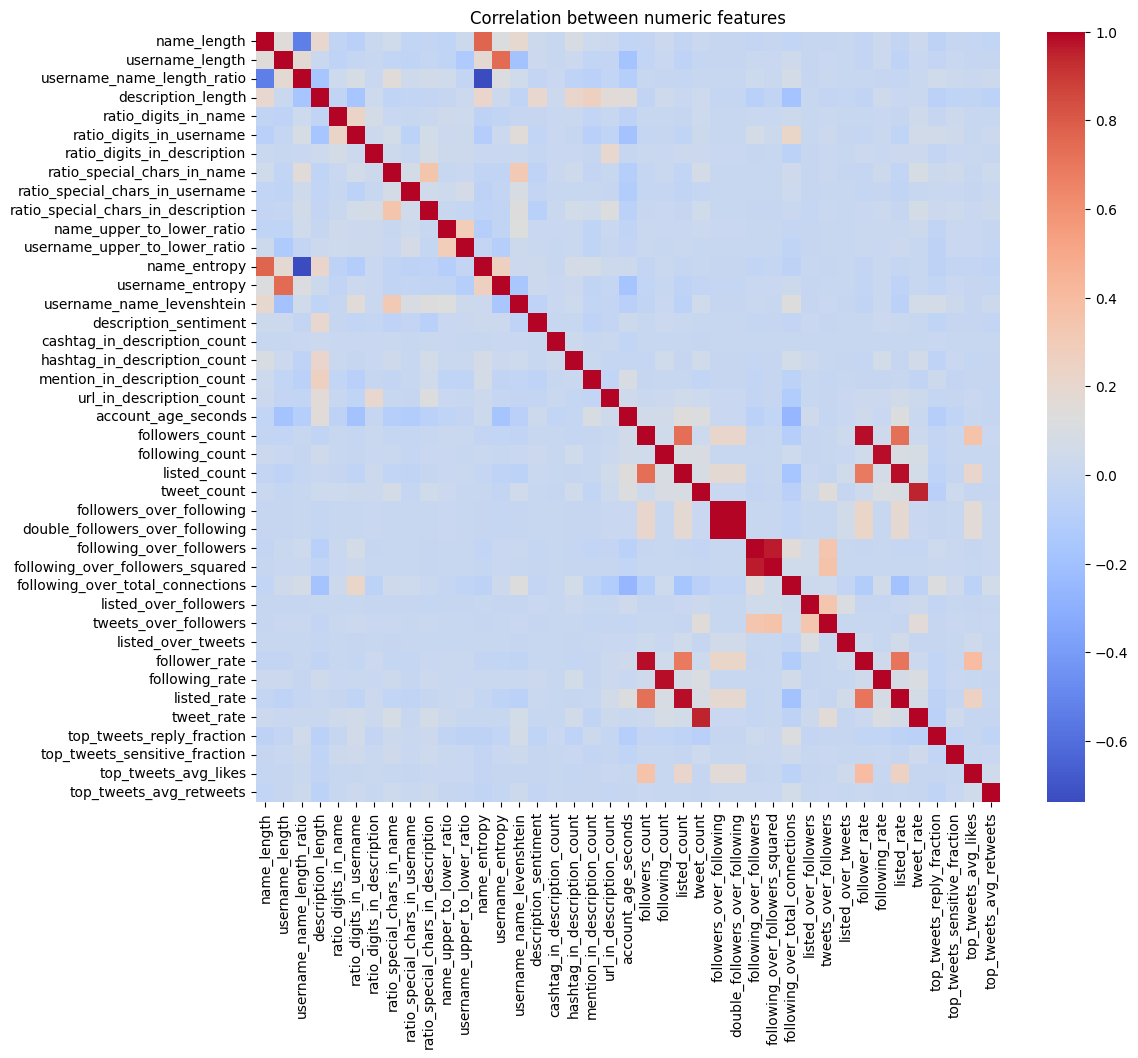

In [21]:
# Check pairwise correlations between numeric features
corr_matrix = X_train[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

In [22]:
from itertools import combinations

threshold = 0.8
high_corr = []

for col1, col2 in combinations(numeric_cols, 2):
    corr_val = corr_matrix.loc[col1, col2]
    if abs(corr_val) > threshold:
        high_corr.append((col1, col2, corr_val))

print("Highly correlated pairs (|| > 0.8):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} - {col2}: {corr_val:.2f}")

Highly correlated pairs (|| > 0.8):
followers_count - follower_rate: 0.98
following_count - following_rate: 0.98
listed_count - listed_rate: 0.99
tweet_count - tweet_rate: 0.95
followers_over_following - double_followers_over_following: 1.00
following_over_followers - following_over_followers_squared: 0.96


In [23]:
# Check for numeric/boolean features with low variance
variances = X_train[numeric_bool_cols].var()

low_variance = variances[variances < 0.01].sort_values()

print("Features with variance < 0.01:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.01:
has_username: 0.000000
listed_rate: 0.000000
following_rate: 0.000000
tweet_rate: 0.000000
follower_rate: 0.000004
has_name: 0.000020
ratio_digits_in_description: 0.000753
has_bot_word_in_name: 0.000973
ratio_digits_in_name: 0.001434
has_bot_word_in_description: 0.001810
ratio_special_chars_in_username: 0.001892
is_protected: 0.001905
top_tweets_sensitive_fraction: 0.003983


In [24]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [25]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

class SentenceEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", chunk_size=60000):
      self.model_name = model_name
      self.model = SentenceTransformer(self.model_name)

      self.chunk_size = chunk_size

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      if isinstance(X, pd.Series):
        X = X.values

      first_elem = X[0]
      out = np.empty((len(X), 1), dtype=object)

      if isinstance(first_elem, np.ndarray):
        for start in range(0, len(X), self.chunk_size):
          end = min(start + self.chunk_size, len(X))
          batch = X[start:end]

          all_tweets = list(itertools.chain.from_iterable(batch))

          all_embeddings = self.model.encode(all_tweets, batch_size=1024, show_progress_bar=True, device=device)

          lengths = [len(lst) for lst in batch]
          splits = np.cumsum(lengths)[:-1]
          grouped = np.split(all_embeddings, splits)

          mean_embs = np.array([g.mean(axis=0) for g in grouped])
          out[start:end, 0] = list(mean_embs)

          torch.cuda.empty_cache()

      else:
        embeddings = self.model.encode(X, batch_size=1024, show_progress_bar=True, device=device)  # (n_samples, embedding_dim)
        out[:, 0] = list(embeddings)

      torch.cuda.empty_cache()

      return out

In [26]:
'''
desc_column = text_cols[0]
tweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]

if lang_version[1:] == "all_lang":
    desc_embedding_model = "distiluse-base-multilingual-cased-v1"

    if embedding_version[1:] in ["v1", "v3"]:
        tweet_embedding_model = "distiluse-base-multilingual-cased-v1"
    elif embedding_version[1:] in ["v2", "v4"]:
        tweet_embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"

elif lang_version[1:] == "en":
    desc_embedding_model = "all-MiniLM-L6-v2"

    if embedding_version[1:] in ["v1", "v3"]:
        tweet_embedding_model = "all-MiniLM-L6-v2"
    elif embedding_version[1:] in ["v2", "v4"]:
        tweet_embedding_model = "paraphrase-MiniLM-L6-v2"
'''

'\ndesc_column = text_cols[0]\ntweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]\n\nif lang_version[1:] == "all_lang":\n    desc_embedding_model = "distiluse-base-multilingual-cased-v1"\n\n    if embedding_version[1:] in ["v1", "v3"]:\n        tweet_embedding_model = "distiluse-base-multilingual-cased-v1"\n    elif embedding_version[1:] in ["v2", "v4"]:\n        tweet_embedding_model = "paraphrase-multilingual-MiniLM-L12-v2"\n\nelif lang_version[1:] == "en":\n    desc_embedding_model = "all-MiniLM-L6-v2"\n\n    if embedding_version[1:] in ["v1", "v3"]:\n        tweet_embedding_model = "all-MiniLM-L6-v2"\n    elif embedding_version[1:] in ["v2", "v4"]:\n        tweet_embedding_model = "paraphrase-MiniLM-L6-v2"\n'

In [27]:
'''
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),
    ("desc_text_embedding", SentenceEmbedder(f"sentence-transformers/{desc_embedding_model}"), desc_column),
    ("tweet_text_embedding", SentenceEmbedder(f"sentence-transformers/{tweet_embedding_model}"), tweet_column)
    ], remainder="drop")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)
'''

'\nfrom sklearn.feature_selection import VarianceThreshold, SelectFromModel\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\n\nnumeric_bool_pipeline = Pipeline([\n    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01\n    ("model_sel", SelectFromModel(\n        GradientBoostingClassifier(n_estimators=100, random_state=42),\n        threshold="median"  # keep features above median importance\n    ))\n])\n\npreprocessor = ColumnTransformer([\n    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),\n    ("desc_text_embedding", SentenceEmbedder(f"sentence-transformers/{desc_embedding_model}"), desc_column),\n    ("tweet_text_embedding", SentenceEmbedder(f"sentence-transformers/{tweet_embedding_model}"), tweet_column)\n    ], remainder="drop")\n\n# Fit on training set\npreprocessor.fit(X_train, y_train)\n\n# Transform train/test sets\nX_tra

In [28]:
'''
np.save(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", X_train_selected)
np.save(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", X_test_selected)
'''

'\nnp.save(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", X_train_selected)\nnp.save(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", X_test_selected)\n'

In [29]:
'''
import joblib

numeric_bool_pipeline_fitted = preprocessor.named_transformers_['numeric_bool_pipeline']
joblib.dump(numeric_bool_pipeline_fitted, f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")
'''

'\nimport joblib\n\nnumeric_bool_pipeline_fitted = preprocessor.named_transformers_[\'numeric_bool_pipeline\']\njoblib.dump(numeric_bool_pipeline_fitted, f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")\n'

In [30]:
'''
metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": desc_column,
    "tweet_column": tweet_column,
    "desc_embedding_model": desc_embedding_model,
    "tweet_embedding_model": tweet_embedding_model
}

metadata_df = pd.DataFrame([metadata])
metadata_df.to_csv(f"{path}{lang_version}{embedding_version}/metadata.csv", index=False)
'''

'\nmetadata = {\n    "lang_version": lang_version[1:],\n    "embedding_version": embedding_version[1:],\n    "desc_column": desc_column,\n    "tweet_column": tweet_column,\n    "desc_embedding_model": desc_embedding_model,\n    "tweet_embedding_model": tweet_embedding_model\n}\n\nmetadata_df = pd.DataFrame([metadata])\nmetadata_df.to_csv(f"{path}{lang_version}{embedding_version}/metadata.csv", index=False)\n'

In [31]:
import numpy as np

X_train_selected = np.load(f"{path}{lang_version}{embedding_version}/X_train_selected.npy", allow_pickle=True)
X_test_selected = np.load(f"{path}{lang_version}{embedding_version}/X_test_selected.npy", allow_pickle=True)

In [32]:
import joblib

numeric_bool_pipeline_fitted = joblib.load(f"{path}{lang_version}{embedding_version}/numeric_bool_pipeline_fitted.joblib")

In [33]:
desc_column = text_cols[0]
tweet_column = text_cols[1] if embedding_version[1:] in ["v1", "v2"] else text_cols[2]

var_mask = numeric_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = numeric_bool_cols[var_mask]

sfm = numeric_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
numeric_bool_cols_selected = cols_after_var[model_mask]

all_selected_cols = list(numeric_bool_cols_selected) + [desc_column, tweet_column]

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols, index=X_test.index)

# Restore feature types
numeric_cols_selected = [col for col in numeric_bool_cols_selected if col in numeric_cols]
bool_cols_selected = [col for col in numeric_bool_cols_selected if col in bool_cols]

X_train_selected_df[numeric_cols_selected] = X_train_selected_df[numeric_cols_selected].astype(float)
X_test_selected_df[numeric_cols_selected] = X_test_selected_df[numeric_cols_selected].astype(float)

X_train_selected_df[bool_cols_selected] = X_train_selected_df[bool_cols_selected].astype(int)
X_test_selected_df[bool_cols_selected] = X_test_selected_df[bool_cols_selected].astype(int)

In [34]:
X_train.head(2)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
15895,13,12,0.923077,"Artists in conversation, since 1981. Quarterly...",75,True,True,True,True,True,True,False,False,0.000000,0.000000,0.053333,0.000000,0.000000,0.053333,0.714286,0.500000,3.238901,3.251629,0.153846,0.000000,0,0,0,0,False,True,527508167,56424,2666,1961,16118,21.164291,42.328582,0.047249,0.000001,0.045118,0.034755,0.285659,0.121665,0.000107,0.000005,0.000004,0.000031,"""Our world is already entwined so thoroughly i...","[""Our world is already entwined so thoroughly ...",0.000000,0.000000,4.000000,1.000000
74936,14,13,0.928571,Admissions Program Manager <USER> | BA ‘14 <US...,155,True,True,True,False,True,True,False,False,0.000000,0.000000,0.025806,0.000000,0.000000,0.083871,0.181818,0.000000,3.182006,3.026987,0.214286,0.318200,0,0,5,0,False,False,438681090,246,272,2,1332,0.904412,1.808824,1.105691,0.004495,0.525097,0.008130,5.414634,0.001502,0.000001,0.000001,0.000000,0.000003,"<USER> <USER> we were ahead of our time, I gue...","[<USER> <USER> we were ahead of our time, I gu...",0.600000,0.000000,3.500000,2284.300000


In [35]:
X_train_selected_df.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,double_followers_over_following,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_reply_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_texts
15895,13.000000,0.923077,75.000000,0.000000,0.053333,0.000000,527508167.000000,56424.000000,2666.000000,16118.000000,42.328582,0.034755,0.285659,0.121665,0.000000,4.000000,1.000000,1,1,"[-0.0053258208, -0.03813503, -0.04280077, 0.04...","[-0.022621462, 0.27639517, -0.13710691, 0.0971..."
74936,14.000000,0.928571,155.000000,0.000000,0.083871,0.000000,438681090.000000,246.000000,272.000000,1332.000000,1.808824,0.008130,5.414634,0.001502,0.600000,3.500000,2284.300000,1,0,"[0.013557132, -0.040924843, 0.05862683, -0.012...","[-0.0962665, 0.027507398, 0.069793545, -0.3721..."


In [36]:
X_train_selected_df.dtypes

,0
name_length,float64
username_name_length_ratio,float64
description_length,float64
ratio_special_chars_in_name,float64
ratio_special_chars_in_description,float64
hashtag_in_description_count,float64
account_age_seconds,float64
followers_count,float64
following_count,float64
tweet_count,float64


In [37]:
print("Selected numeric/boolean features:")
print(list(numeric_bool_cols_selected))

Selected numeric/boolean features:
['name_length', 'username_name_length_ratio', 'description_length', 'ratio_special_chars_in_name', 'ratio_special_chars_in_description', 'hashtag_in_description_count', 'account_age_seconds', 'followers_count', 'following_count', 'tweet_count', 'double_followers_over_following', 'listed_over_followers', 'tweets_over_followers', 'listed_over_tweets', 'top_tweets_reply_fraction', 'top_tweets_avg_likes', 'top_tweets_avg_retweets', 'has_description', 'is_verified']


In [38]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": numeric_bool_cols_selected,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                               feature  importance
7                      followers_count    0.497149
2                   description_length    0.140224
9                          tweet_count    0.103552
8                      following_count    0.067833
17                     has_description    0.063071
16             top_tweets_avg_retweets    0.030339
18                         is_verified    0.023033
6                  account_age_seconds    0.021680
1           username_name_length_ratio    0.010554
5         hashtag_in_description_count    0.005825
0                          name_length    0.005472
11               listed_over_followers    0.004980
10     double_followers_over_following    0.003283
13                  listed_over_tweets    0.003020
4   ratio_special_chars_in_description    0.002651
15                top_tweets_avg_likes    0.002174
3          ratio_special_chars_in_name    0.002118
12               tweets_over_followers    0.001861
14           top_tweets_reply_f

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_selected_df[numeric_cols_selected])

# Transform train/test sets
X_train_scaled = X_train_selected_df.copy()
X_test_scaled = X_test_selected_df.copy()

X_train_scaled[numeric_cols_selected] = scaler.transform(X_train_selected_df[numeric_cols_selected])
X_test_scaled[numeric_cols_selected] = scaler.transform(X_test_selected_df[numeric_cols_selected])

In [40]:
X_train_scaled.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,double_followers_over_following,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_reply_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_texts
15895,-0.245741,-0.025607,-0.639718,-0.366547,-0.267239,-0.366725,1.074030,-0.022257,-0.016186,-0.150725,-0.019973,0.045938,-0.039378,0.000870,-0.742793,-0.050522,-0.129957,1,1,"[-0.0053258208, -0.03813503, -0.04280077, 0.04...","[-0.022621462, 0.27639517, -0.13710691, 0.0971..."
74936,-0.112757,-0.018243,0.966815,-0.366547,0.007579,-0.366725,0.404276,-0.082137,-0.142261,-0.316678,-0.020133,-0.102626,-0.027607,-0.021956,1.449573,-0.050764,0.233101,1,0,"[0.013557132, -0.040924843, 0.05862683, -0.012...","[-0.0962665, 0.027507398, 0.069793545, -0.3721..."


In [67]:
from torch import nn

class MultiBranchNN(nn.Module):
  def __init__(self, numeric_dim, desc_text_dim, tweet_text_dim, hidden_dim=128, out_dim=1, dropout=0.5):
    super(MultiBranchNN, self).__init__()

    # Branch for numeric + boolean features
    self.numeric_branch = nn.Sequential(
        nn.Linear(numeric_dim, hidden_dim // 2),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for description text embeddings
    self.desc_branch = nn.Sequential(
        nn.Linear(desc_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for tweet text embeddings
    self.tweet_branch = nn.Sequential(
        nn.Linear(tweet_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Combined layers
    self.combined = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, out_dim)
        )

  def forward(self, x_numeric, x_desc, x_tweet):
    # Process each branch
    num_feat = self.numeric_branch(x_numeric)
    desc_feat = self.desc_branch(x_desc)
    tweet_feat = self.tweet_branch(x_tweet)

    # Concatenate branch outputs
    x = torch.cat([num_feat, desc_feat, tweet_feat], dim=1)

    # Final layers
    x = self.combined(x)
    return x

In [59]:
X_train_numeric_bool = X_train_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_train_desc = np.stack(X_train_scaled[desc_column].values)
X_train_tweet = np.stack(X_train_scaled[tweet_column].values)

X_test_numeric_bool = X_test_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_test_desc = np.stack(X_test_scaled[desc_column].values)
X_test_tweet = np.stack(X_test_scaled[tweet_column].values)

In [60]:
X_train_combined = np.hstack([X_train_numeric_bool, X_train_desc, X_train_tweet])
X_train_combined.shape

(250404, 787)

In [61]:
from imblearn.over_sampling import SMOTE

sampling_strategy = 0.5
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=sampling_strategy, random_state=42).fit_resample(X_train_combined, y_train)

In [62]:
y_train_resampled.value_counts(normalize=True)

,proportion
label,
0,0.666668
1,0.333332


In [63]:
num_dim = X_train_numeric_bool.shape[1]
desc_dim = X_train_desc.shape[1]
tweet_dim = X_train_tweet.shape[1]

X_train_numeric_resampled = X_train_resampled[:, :num_dim]
X_train_desc_resampled = X_train_resampled[:, num_dim:num_dim+desc_dim]
X_train_tweet_resampled = X_train_resampled[:, num_dim+desc_dim:]

In [64]:
X_train_tweet_resampled.shape

(346147, 384)

In [65]:
X_train_numeric_tensor = torch.from_numpy(X_train_numeric_resampled)
X_train_desc_tensor = torch.from_numpy(X_train_desc_resampled)
X_train_tweet_tensor = torch.from_numpy(X_train_tweet_resampled)

y_train_tensor = torch.from_numpy(y_train_resampled.values).float()

X_test_numeric_tensor = torch.from_numpy(X_test_numeric_bool)
X_test_desc_tensor = torch.from_numpy(X_test_desc)
X_test_tweet_tensor = torch.from_numpy(X_test_tweet)

y_test_tensor = torch.from_numpy(y_test.values).float()

In [66]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(
    X_train_numeric_tensor,
    X_train_desc_tensor,
    X_train_tweet_tensor,
    y_train_tensor
    )
test_dataset = TensorDataset(
    X_test_numeric_tensor,
    X_test_desc_tensor,
    X_test_tweet_tensor,
    y_test_tensor
    )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [68]:
numeric_dim = X_train_numeric_tensor.shape[1]
desc_text_dim = X_train_desc_tensor.shape[1]
tweet_text_dim = X_train_tweet_tensor.shape[1]

hidden_dim = 256
dropout = 0.5

model = MultiBranchNN(
    numeric_dim=numeric_dim,
    desc_text_dim=desc_text_dim,
    tweet_text_dim=tweet_text_dim,
    hidden_dim=hidden_dim,
    out_dim=1,
    dropout=dropout
    ).to(device)

criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
weight_decay = 0

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for x_num, x_desc, x_tweet, y in dataloader:
    x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(x_num, x_desc, x_tweet)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x_num.size(0)

  return total_loss / len(dataloader.dataset)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device, pred_threshold):
  model.eval()
  total_loss = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
      for x_num, x_desc, x_tweet, y in dataloader:
          x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)
          outputs = model(x_num, x_desc, x_tweet)
          loss = criterion(outputs, y)
          total_loss += loss.item() * x_num.size(0)

          preds = (torch.sigmoid(outputs) > pred_threshold).float()
          all_preds.append(preds.cpu())
          all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)

  accuracy = (all_preds == all_targets).sum().item() / len(all_targets)
  f1 = f1_score(all_targets.numpy(), all_preds.numpy())
  precision = precision_score(all_targets.numpy(), all_preds.numpy())
  recall = recall_score(all_targets.numpy(), all_preds.numpy())

  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, accuracy, f1, precision, recall

In [ ]:
'''
pred_threshold = 0.5

metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": desc_column,
    "tweet_column": tweet_column,
    "sampling_strategy": sampling_strategy,
    "batch_size": batch_size,
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay,
    "pred_threshold": pred_threshold
}

metadata_df = pd.DataFrame([metadata])

num_epochs = 100
results = []

for epoch in range(1, num_epochs + 1):
  train_loss = train(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device, pred_threshold)

  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

  results.append({
      "epoch": epoch,
      "train_loss": train_loss,
      "test_loss": test_loss,
      "test_acc": test_acc,
      "test_f1": test_f1,
      "test_prec": test_prec,
      "test_rec": test_rec
      })

results_df = pd.DataFrame(results)

excel_path = f"{path}{lang_version}{embedding_version}/results.xlsx"

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
  metadata_df.to_excel(writer, sheet_name="metadata", index=False)
  results_df.to_excel(writer, sheet_name="results", index=False)
'''

'\npred_threshold = 0.5\n\nmetadata = {\n    "lang_version": lang_version[1:],\n    "embedding_version": embedding_version[1:],\n    "desc_column": desc_column,\n    "tweet_column": tweet_column,\n    "sampling_strategy": sampling_strategy,\n    "batch_size": batch_size,\n    "hidden_dim": hidden_dim,\n    "dropout": dropout,\n    "lr": lr,\n    "weight_decay": weight_decay,\n    "pred_threshold": pred_threshold\n}\n\nmetadata_df = pd.DataFrame([metadata])\n\nnum_epochs = 100\nresults = []\n\nfor epoch in range(1, num_epochs + 1):\n  train_loss = train(model, train_loader, criterion, optimizer, device)\n  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device, pred_threshold)\n\n  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "\n        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")\n\n  results.append({\n      "epoch": epoch,\n      "trai

In [ ]:
def compute_f1(model, dataloader, device, pred_threshold=0.5):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for x_num, x_desc, x_tweet, y in dataloader:
          x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)
          outputs = torch.sigmoid(model(x_num, x_desc, x_tweet))
          preds = (outputs > pred_threshold).float()
          all_preds.append(preds.cpu())
          all_targets.append(y.cpu())
  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)
  return f1_score(all_targets.numpy(), all_preds.numpy())

In [ ]:
from sklearn.model_selection import KFold

def cross_validate_model(X_num, X_desc, X_tweet, y, params, device, num_epochs=50, n_splits=5, patience=3):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  best_f1_scores = []

  for fold, (train_idx, val_idx) in enumerate(kf.split(X_num)):
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")

    X_train_num, X_val_num = X_num[train_idx], X_num[val_idx]
    X_train_desc, X_val_desc = X_desc[train_idx], X_desc[val_idx]
    X_train_tweet, X_val_tweet = X_tweet[train_idx], X_tweet[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train_num),
        torch.from_numpy(X_train_desc),
        torch.from_numpy(X_train_tweet),
        torch.from_numpy(y_train.values).float()
        )
    val_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_val_num),
        torch.from_numpy(X_val_desc),
        torch.from_numpy(X_val_tweet),
        torch.from_numpy(y_val.values).float()
        )
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

    model = MultiBranchNN(
        numeric_dim=X_train_num.shape[1],
        desc_text_dim=X_train_desc.shape[1],
        tweet_text_dim=X_train_tweet.shape[1],
        hidden_dim=params["hidden_dim"],
        dropout=params["dropout"]
        ).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    best_f1 = 0
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
      train(model, train_loader, criterion, optimizer, device)
      f1 = compute_f1(model, val_loader, device)

      print(f"Epoch {epoch:02d} | Val F1: {f1:.4f}")

      if f1 > best_f1:
        best_f1 = f1
        best_epoch = epoch
        epochs_no_improve = 0
      else:
        epochs_no_improve += 1

      if epochs_no_improve >= patience:
        break

    print(f"\nFold {fold + 1}: Best Val F1 = {best_f1:.4f} (Epoch {best_epoch:02d})")
    best_f1_scores.append(best_f1)

  mean_best_f1 = np.mean(best_f1_scores)
  print(f"\nMean Best F1 across folds: {mean_best_f1:.4f}")

  return mean_best_f1

In [ ]:
'''
import random

num_combinations = 10
num_epochs = 50

param_grid = {
    "batch_size": [16, 32, 64],
    "hidden_dim": [64, 128, 256],
    "dropout": [0.3, 0.5, 0.7],
    "lr": [1e-2, 1e-3, 5e-4],
    "weight_decay": [0, 1e-5, 1e-4]
    }

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
sampled_combinations = random.sample(param_combinations, num_combinations)

all_results = []

for i, params in enumerate(sampled_combinations):
  print(f"=== Grid Search {i+1}/{len(sampled_combinations)} | Params: {params} ===")
  mean_best_f1 = cross_validate_model(
      X_num=X_train_numeric_resampled,
      X_desc=X_train_desc_resampled,
      X_tweet=X_train_tweet_resampled,
      y=y_train_resampled,
      params=params,
      device=device,
      num_epochs=num_epochs,
      n_splits=5
      )
  iteration_result = {**params, "mean_best_f1": mean_best_f1}
  all_results.append(iteration_result)

results_df = pd.DataFrame(all_results)
results_df.to_csv(f"{path}{lang_version}{embedding_version}/cv_results_{num_combinations}_{num_epochs}.csv", index=False)
'''

'\nimport random\n\nnum_combinations = 10\nnum_epochs = 50\n\nparam_grid = {\n    "batch_size": [16, 32, 64],\n    "hidden_dim": [64, 128, 256],\n    "dropout": [0.3, 0.5, 0.7],\n    "lr": [1e-2, 1e-3, 5e-4],\n    "weight_decay": [0, 1e-5, 1e-4]\n    }\n\nkeys, values = zip(*param_grid.items())\nparam_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]\nsampled_combinations = random.sample(param_combinations, num_combinations)\n\nall_results = []\n\nfor i, params in enumerate(sampled_combinations):\n  print(f"=== Grid Search {i+1}/{len(sampled_combinations)} | Params: {params} ===")\n  mean_best_f1 = cross_validate_model(\n      X_num=X_train_numeric_resampled,\n      X_desc=X_train_desc_resampled,\n      X_tweet=X_train_tweet_resampled,\n      y=y_train_resampled,\n      params=params,\n      device=device,\n      num_epochs=num_epochs,\n      n_splits=5\n      )\n  iteration_result = {**params, "mean_best_f1": mean_best_f1}\n  all_results.append(iteration_result)\

In [41]:
X_train_scaled["description"].apply(lambda x: np.linalg.norm(np.asarray(x))).describe()

,description
count,250404.000000
mean,1.000000
std,0.000000
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [42]:
X_train_scaled["top_tweets_texts"].apply(lambda x: np.linalg.norm(np.asarray(x))).describe()

,top_tweets_texts
count,250404.000000
mean,3.320963
std,1.000451
min,1.488765
25%,2.642897
50%,2.990303
75%,3.697837
max,9.235671


In [43]:
from sklearn.preprocessing import normalize

def get_normalized_embeddings(df, colname):
  X = np.vstack(df[colname].values)
  Xn = normalize(X, norm="l2")
  return Xn

In [44]:
X_train_desc_values = get_normalized_embeddings(X_train_scaled, "description")
X_train_tweet_values = get_normalized_embeddings(X_train_scaled, "top_tweets_texts")

y_train_values = y_train.values

In [45]:
np.allclose(np.linalg.norm(X_train_desc_values, axis=1), 1.0, atol=1e-6)

True

In [46]:
np.allclose(np.linalg.norm(X_train_tweet_values, axis=1), 1.0, atol=1e-6)

True

In [47]:
rng = np.random.default_rng(42)

idx_bot = np.where(y_train == 1)[0]
idx_human = np.where(y_train == 0)[0]

idx_human_sub = rng.choice(idx_human, size=len(idx_bot), replace=False)
idx_balanced = np.concatenate([idx_bot, idx_human_sub])

X_train_desc_balanced = X_train_desc_values[idx_balanced]
X_train_tweet_balanced = X_train_tweet_values[idx_balanced]
y_train_balanced = y_train_values[idx_balanced]

In [48]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_train_desc_2d = umap_model.fit_transform(X_train_desc_balanced)
X_train_tweet_2d = umap_model.fit_transform(X_train_tweet_balanced)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [49]:
# Description centroids (UMAP space)
c_desc_2d_h = X_train_desc_2d[y_train_balanced == 0].mean(axis=0)
c_desc_2d_b = X_train_desc_2d[y_train_balanced == 1].mean(axis=0)

# Top tweets centroids (UMAP space)
c_tweet_2d_h = X_train_tweet_2d[y_train_balanced == 0].mean(axis=0)
c_tweet_2d_b = X_train_tweet_2d[y_train_balanced == 1].mean(axis=0)

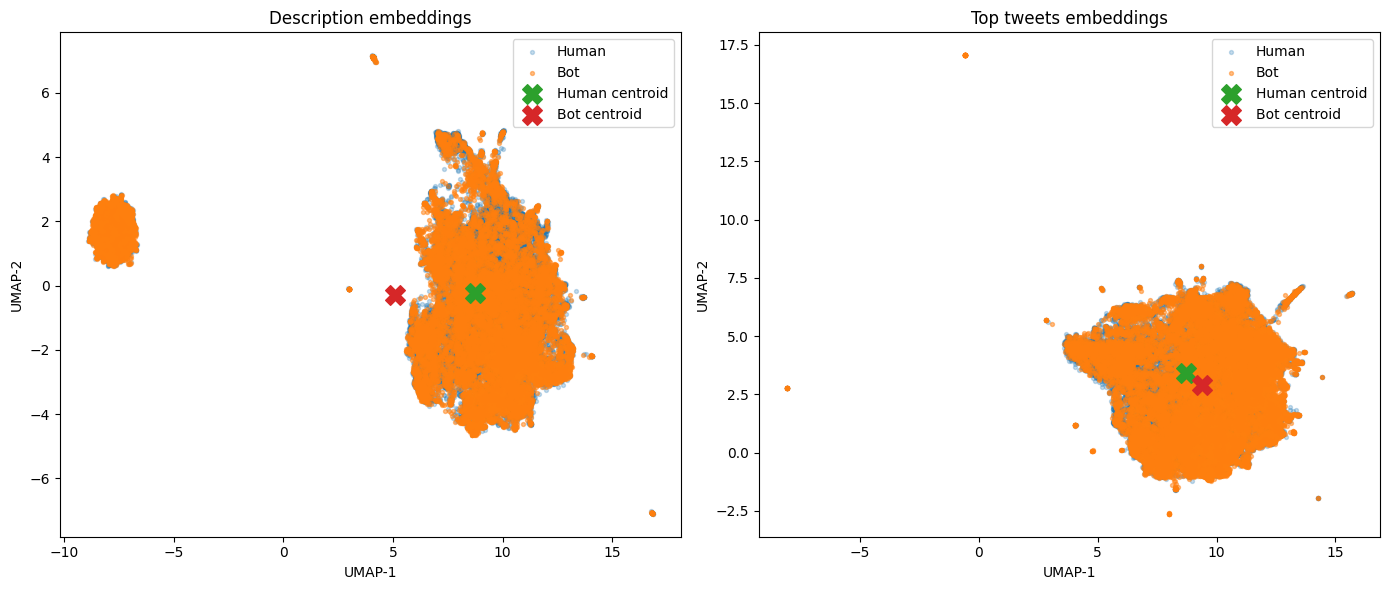

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# Description embeddings
axes[0].scatter(
    X_train_desc_2d[y_train_balanced==0, 0], X_train_desc_2d[y_train_balanced==0, 1],
    s=8, alpha=0.25, label="Human"
)
axes[0].scatter(
    X_train_desc_2d[y_train_balanced==1, 0], X_train_desc_2d[y_train_balanced==1, 1],
    s=8, alpha=0.5, label="Bot"
)
axes[0].scatter(
    *c_desc_2d_h,
    marker="X", s=200, linewidths=1,
    label="Human centroid"
)
axes[0].scatter(
    *c_desc_2d_b,
    marker="X", s=200, linewidths=1,
    label="Bot centroid"
)
axes[0].set_title("Description embeddings")

# Top tweets embeddings
axes[1].scatter(
    X_train_tweet_2d[y_train_balanced==0, 0], X_train_tweet_2d[y_train_balanced==0, 1],
    s=8, alpha=0.25, label="Human"
)
axes[1].scatter(
    X_train_tweet_2d[y_train_balanced==1, 0], X_train_tweet_2d[y_train_balanced==1, 1],
    s=8, alpha=0.5, label="Bot"
)
axes[1].scatter(
    *c_tweet_2d_h,
    marker="X", s=200, linewidths=1,
    label="Human centroid"
)
axes[1].scatter(
    *c_tweet_2d_b,
    marker="X", s=200, linewidths=1,
    label="Bot centroid"
)
axes[1].set_title("Top tweets embeddings")

for ax in axes:
    ax.legend()
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.tight_layout()
plt.show()

In [52]:
from numpy.linalg import norm

c_desc_h = X_train_desc_balanced[y_train_balanced==0].mean(axis=0)
c_desc_b = X_train_desc_balanced[y_train_balanced==1].mean(axis=0)

cos_dist_desc = 1 - np.dot(c_desc_h, c_desc_b) / (norm(c_desc_h) * norm(c_desc_b))
print("Description centroid cosine distance:", cos_dist_desc)

Description centroid cosine distance: 0.1411261


In [53]:
c_tweet_h = X_train_tweet_balanced[y_train_balanced==0].mean(axis=0)
c_tweet_b = X_train_tweet_balanced[y_train_balanced==1].mean(axis=0)

cos_dist_tweet = 1 - np.dot(c_tweet_h, c_tweet_b) / (norm(c_tweet_h) * norm(c_tweet_b))
print("Top tweets centroid cosine distance:", cos_dist_tweet)

Top tweets centroid cosine distance: 0.008131683


In [55]:
from sklearn.metrics.pairwise import cosine_distances

X_train_desc_h = X_train_desc_balanced[y_train_balanced==0]
X_train_desc_b = X_train_desc_balanced[y_train_balanced==1]

D_desc_hh = cosine_distances(X_train_desc_h, X_train_desc_h).mean()
D_desc_bb = cosine_distances(X_train_desc_b, X_train_desc_b).mean()
D_desc_hb = cosine_distances(X_train_desc_h, X_train_desc_b).mean()

print(D_desc_hb)

0.8645842


In [56]:
0.5*(D_desc_hh + D_desc_bb)

np.float32(0.8403444)

In [57]:
X_train_tweet_h = X_train_tweet_balanced[y_train_balanced==0]
X_train_tweet_b = X_train_tweet_balanced[y_train_balanced==1]

D_tweet_hh = cosine_distances(X_train_tweet_h, X_train_tweet_h).mean()
D_tweet_bb = cosine_distances(X_train_tweet_b, X_train_tweet_b).mean()
D_tweet_hb = cosine_distances(X_train_tweet_h, X_train_tweet_b).mean()

print(D_tweet_hb)

0.6028886


In [58]:
0.5*(D_tweet_hh + D_tweet_bb)

np.float32(0.5996249)

In [71]:
import torch
from torch import nn

class NumericNN(nn.Module):
  def __init__(self, numeric_dim, hidden_dim=128, out_dim=1, dropout=0.5):
    super(NumericNN, self).__init__()
    self.numeric_branch = nn.Sequential(
        nn.Linear(numeric_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
    )
    self.combined = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, out_dim)
    )

  def forward(self, x_numeric):
    x = self.numeric_branch(x_numeric)
    x = self.combined(x)
    return x

In [72]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(
    X_train_numeric_tensor,
    y_train_tensor
)

test_dataset = TensorDataset(
    X_test_numeric_tensor,
    y_test_tensor
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [73]:
import torch
from torch import nn, optim

numeric_dim = X_train_numeric_tensor.shape[1]

hidden_dim = 256
dropout = 0.5

model = NumericNN(
    numeric_dim=numeric_dim,
    hidden_dim=hidden_dim,
    out_dim=1,
    dropout=dropout
).to(device)

criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
weight_decay = 0
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [74]:
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for x_num, y in dataloader:
    x_num, y = x_num.to(device), y.to(device).unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(x_num)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x_num.size(0)

  return total_loss / len(dataloader.dataset)

In [75]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device, pred_threshold=0.5):
  model.eval()
  total_loss = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
    for x_num, y in dataloader:
      x_num, y = x_num.to(device), y.to(device).unsqueeze(1)

      outputs = model(x_num)
      loss = criterion(outputs, y)
      total_loss += loss.item() * x_num.size(0)

      preds = (torch.sigmoid(outputs) > pred_threshold).float()
      all_preds.append(preds.cpu())
      all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)

  accuracy = (all_preds == all_targets).sum().item() / len(all_targets)
  f1 = f1_score(all_targets.numpy(), all_preds.numpy())
  precision = precision_score(all_targets.numpy(), all_preds.numpy())
  recall = recall_score(all_targets.numpy(), all_preds.numpy())

  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, accuracy, f1, precision, recall

In [76]:
'''
pred_threshold = 0.5

metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": None,
    "tweet_column": None,
    "sampling_strategy": sampling_strategy,
    "batch_size": batch_size,
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay,
    "pred_threshold": pred_threshold
}

metadata_df = pd.DataFrame([metadata])

num_epochs = 100
results = []

for epoch in range(1, num_epochs + 1):
  train_loss = train(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(
      model, test_loader, criterion, device, pred_threshold
  )

  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

  results.append({
      "epoch": epoch,
      "train_loss": train_loss,
      "test_loss": test_loss,
      "test_acc": test_acc,
      "test_f1": test_f1,
      "test_prec": test_prec,
      "test_rec": test_rec
  })

results_df = pd.DataFrame(results)

excel_path = f"{path}{lang_version}{embedding_version}/results_numeric_only.xlsx"

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
  metadata_df.to_excel(writer, sheet_name="metadata", index=False)
  results_df.to_excel(writer, sheet_name="results", index=False)
'''

Epoch 01 | Train Loss: 0.4782 | Test Loss: 0.3645 | Test Acc: 0.8370 | Test F1: 0.3552 | Test Prec: 0.2575 | Test Rec: 0.5724
Epoch 02 | Train Loss: 0.4587 | Test Loss: 0.3577 | Test Acc: 0.8351 | Test F1: 0.3568 | Test Prec: 0.2570 | Test Rec: 0.5834
Epoch 03 | Train Loss: 0.4500 | Test Loss: 0.3367 | Test Acc: 0.8528 | Test F1: 0.3731 | Test Prec: 0.2801 | Test Rec: 0.5587
Epoch 04 | Train Loss: 0.4441 | Test Loss: 0.3437 | Test Acc: 0.8359 | Test F1: 0.3662 | Test Prec: 0.2627 | Test Rec: 0.6045
Epoch 05 | Train Loss: 0.4397 | Test Loss: 0.3450 | Test Acc: 0.8403 | Test F1: 0.3672 | Test Prec: 0.2664 | Test Rec: 0.5907
Epoch 06 | Train Loss: 0.4373 | Test Loss: 0.3385 | Test Acc: 0.8469 | Test F1: 0.3738 | Test Prec: 0.2751 | Test Rec: 0.5830
Epoch 07 | Train Loss: 0.4356 | Test Loss: 0.3314 | Test Acc: 0.8587 | Test F1: 0.3805 | Test Prec: 0.2899 | Test Rec: 0.5532
Epoch 08 | Train Loss: 0.4338 | Test Loss: 0.3361 | Test Acc: 0.8499 | Test F1: 0.3788 | Test Prec: 0.2804 | Test Rec:

In [79]:
from torch import nn
import torch

class TextOnlyNN(nn.Module):
  def __init__(self, desc_text_dim, tweet_text_dim, hidden_dim=128, out_dim=1, dropout=0.5):
    super(TextOnlyNN, self).__init__()

    # Branch for description text embeddings
    self.desc_branch = nn.Sequential(
        nn.Linear(desc_text_dim, hidden_dim // 2),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
    )

    # Branch for tweet text embeddings
    self.tweet_branch = nn.Sequential(
        nn.Linear(tweet_text_dim, hidden_dim // 2),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
    )

    # Combined layers
    self.combined = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, out_dim)
    )

  def forward(self, x_desc, x_tweet):
    # Process each branch
    desc_feat = self.desc_branch(x_desc)
    tweet_feat = self.tweet_branch(x_tweet)

    # Concatenate branch outputs
    x = torch.cat([desc_feat, tweet_feat], dim=1)

    # Final layers
    x = self.combined(x)
    return x

In [80]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(
    X_train_desc_tensor,
    X_train_tweet_tensor,
    y_train_tensor
)

test_dataset = TensorDataset(
    X_test_desc_tensor,
    X_test_tweet_tensor,
    y_test_tensor
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [81]:
import torch
from torch import nn, optim

desc_text_dim = X_train_desc_tensor.shape[1]
tweet_text_dim = X_train_tweet_tensor.shape[1]

hidden_dim = 256
dropout = 0.5

model = TextOnlyNN(
    desc_text_dim=desc_text_dim,
    tweet_text_dim=tweet_text_dim,
    hidden_dim=hidden_dim,
    out_dim=1,
    dropout=dropout
).to(device)

criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
weight_decay = 0
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [82]:
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for x_desc, x_tweet, y in dataloader:
    x_desc, x_tweet, y = x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(x_desc, x_tweet)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x_desc.size(0)

  return total_loss / len(dataloader.dataset)

In [83]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

def evaluate(model, dataloader, criterion, device, pred_threshold=0.5):
  model.eval()
  total_loss = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
    for x_desc, x_tweet, y in dataloader:
      x_desc, x_tweet, y = x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)

      outputs = model(x_desc, x_tweet)
      loss = criterion(outputs, y)
      total_loss += loss.item() * x_desc.size(0)

      preds = (torch.sigmoid(outputs) > pred_threshold).float()
      all_preds.append(preds.cpu())
      all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds)
  all_targets = torch.cat(all_targets)

  accuracy = (all_preds == all_targets).sum().item() / len(all_targets)
  f1 = f1_score(all_targets.numpy(), all_preds.numpy())
  precision = precision_score(all_targets.numpy(), all_preds.numpy())
  recall = recall_score(all_targets.numpy(), all_preds.numpy())

  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, accuracy, f1, precision, recall

In [86]:
'''
pred_threshold = 0.5

metadata = {
    "lang_version": lang_version[1:],
    "embedding_version": embedding_version[1:],
    "desc_column": desc_column,
    "tweet_column": tweet_column,
    "sampling_strategy": sampling_strategy,
    "batch_size": batch_size,
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "lr": lr,
    "weight_decay": weight_decay,
    "pred_threshold": pred_threshold
}

metadata_df = pd.DataFrame([metadata])

num_epochs = 10
results = []

for epoch in range(1, num_epochs + 1):
  train_loss = train(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(
      model, test_loader, criterion, device, pred_threshold
  )

  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

  results.append({
      "epoch": epoch,
      "train_loss": train_loss,
      "test_loss": test_loss,
      "test_acc": test_acc,
      "test_f1": test_f1,
      "test_prec": test_prec,
      "test_rec": test_rec
  })

results_df = pd.DataFrame(results)

excel_path = f"{path}{lang_version}{embedding_version}/results_text_only.xlsx"

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    metadata_df.to_excel(writer, sheet_name="metadata", index=False)
    results_df.to_excel(writer, sheet_name="results", index=False)
'''

'\npred_threshold = 0.5\n\nmetadata = {\n    "lang_version": lang_version[1:],\n    "embedding_version": embedding_version[1:],\n    "desc_column": desc_column,\n    "tweet_column": tweet_column,\n    "sampling_strategy": sampling_strategy,\n    "batch_size": batch_size,\n    "hidden_dim": hidden_dim,\n    "dropout": dropout,\n    "lr": lr,\n    "weight_decay": weight_decay,\n    "pred_threshold": pred_threshold\n}\n\nmetadata_df = pd.DataFrame([metadata])\n\nnum_epochs = 10\nresults = []\n\nfor epoch in range(1, num_epochs + 1):\n  train_loss = train(model, train_loader, criterion, optimizer, device)\n  test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(\n      model, test_loader, criterion, device, pred_threshold\n  )\n\n  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "\n        f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")\n\n  results.append({\n      "epoch": epoch,\n

In [88]:
X_train.head(1)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
15895,13,12,0.923077,"Artists in conversation, since 1981. Quarterly...",75,True,True,True,True,True,True,False,False,0.000000,0.000000,0.053333,0.000000,0.000000,0.053333,0.714286,0.500000,3.238901,3.251629,0.153846,0.000000,0,0,0,0,False,True,527508167,56424,2666,1961,16118,21.164291,42.328582,0.047249,0.000001,0.045118,0.034755,0.285659,0.121665,0.000107,0.000005,0.000004,0.000031,"""Our world is already entwined so thoroughly i...","[""Our world is already entwined so thoroughly ...",0.000000,0.000000,4.000000,1.000000


In [90]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 25.7 MB/s eta 0:00:00


In [168]:
import re
import emoji

url_token = r"<URL>"
user_token = r"<USER>"
email_token = r"<EMAIL>"
hashtag_pattern = r"#\w+"
digit_pattern = r"\d"
uppercase_pattern = r"[A-Z]"

def compute_description_features(text):
  if not isinstance(text, str) or text.strip() == "":
    return {
        "char_len": None,
        "num_words": None,
        "avg_word_len": None,
        "emoji_count": None,
        "hashtags_count": None,
        "url_count": None,
        "user_count": None,
        "email_count": None,
        "digit_ratio": None,
        "uppercase_ratio": None,
        "repetition_ratio": None
    }

  # Tokenize by whitespace
  words = text.split()
  num_words = len(words)

  # Average word length
  avg_word_len = np.mean([len(w) for w in words]) if words else None

  # Character length
  char_len = len(text)

  # Emojis count
  emoji_count = sum(1 for c in text if c in emoji.EMOJI_DATA)

  # Hashtags count
  hashtags_count = len(re.findall(hashtag_pattern, text))

  # Special tokens count
  url_count = len(re.findall(url_token, text))
  user_count = len(re.findall(user_token, text))
  email_count = len(re.findall(email_token, text))

  # Digit ratio (digits / total chars)
  digits = len(re.findall(digit_pattern, text))
  digit_ratio = digits / char_len if char_len > 0 else None

  # Uppercase ratio (uppercase letters / total letters)
  letters = re.findall(r"[A-Za-z]", text)
  uppercases = len([c for c in letters if c.isupper()])
  uppercase_ratio = uppercases / len(letters) if letters else None

  # Repetition ratio (unique words / total words)
  unique_words = len(set(words))
  repetition_ratio = unique_words / num_words if num_words > 0 else None

  return {
      "char_len": char_len,
      "num_words": num_words,
      "avg_word_len": avg_word_len,
      "emoji_count": emoji_count,
      "hashtags_count": hashtags_count,
      "url_count": url_count,
      "user_count": user_count,
      "email_count": email_count,
      "digit_ratio": digit_ratio,
      "uppercase_ratio": uppercase_ratio,
      "repetition_ratio": repetition_ratio
  }

In [169]:
desc_features_df = X_train['description'].apply(compute_description_features).apply(pd.Series)

X_y_train = pd.concat([X_train, y_train, desc_features_df], axis=1)
X_y_train.head()

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,label,char_len,num_words,avg_word_len,emoji_count,hashtags_count,url_count,user_count,email_count,digit_ratio,uppercase_ratio,repetition_ratio
15895,13,12,0.923077,"Artists in conversation, since 1981. Quarterly...",75,True,True,True,True,True,True,False,False,0.000000,0.000000,0.053333,0.000000,0.000000,0.053333,0.714286,0.500000,3.238901,3.251629,0.153846,0.000000,0,0,0,0,False,True,527508167,56424,2666,1961,16118,21.164291,42.328582,0.047249,0.000001,0.045118,0.034755,0.285659,0.121665,0.000107,0.000005,0.000004,0.000031,"""Our world is already entwined so thoroughly i...","[""Our world is already entwined so thoroughly ...",0.000000,0.000000,4.000000,1.000000,0,75.000000,12.000000,5.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.053333,0.035714,0.916667
74936,14,13,0.928571,Admissions Program Manager <USER> | BA ‘14 <US...,155,True,True,True,False,True,True,False,False,0.000000,0.000000,0.025806,0.000000,0.000000,0.083871,0.181818,0.000000,3.182006,3.026987,0.214286,0.318200,0,0,5,0,False,False,438681090,246,272,2,1332,0.904412,1.808824,1.105691,0.004495,0.525097,0.008130,5.414634,0.001502,0.000001,0.000001,0.000000,0.000003,"<USER> <USER> we were ahead of our time, I gue...","[<USER> <USER> we were ahead of our time, I gu...",0.600000,0.000000,3.500000,2284.300000,1,130.000000,24.000000,4.458333,0.000000,0.000000,0.000000,5.000000,0.000000,0.030769,0.360465,0.625000
72364,32,8,0.250000,<USER> Executive Director | Universal access t...,155,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.156250,0.000000,0.038710,0.142857,0.142857,3.715018,2.750000,0.812500,0.458800,0,0,1,0,False,True,287082837,53300,1059,269,23203,50.330500,100.661001,0.019869,0.000000,0.019482,0.005047,0.435328,0.011593,0.000186,0.000004,0.000001,0.000081,RT <USER>: The humanitarian situation in Ukrai...,[RT <USER>: The humanitarian situation in Ukra...,0.000000,0.000000,6.454545,86.272727,0,155.000000,23.000000,5.782609,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.055556,0.913043
184433,12,11,0.916667,Co Founder <USER>. <USER> - Proudly working wi...,159,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.037736,0.222222,0.222222,3.251629,3.095795,0.083333,0.874800,0,0,2,0,False,False,526559425,3342,651,43,31663,5.133641,10.267281,0.194794,0.000058,0.163035,0.012867,9.474267,0.001358,0.000006,0.000001,0.000000,0.000060,After representing <USER> for 4 years I finall...,[After representing <USER> for 4 years I fina...,0.250000,0.000000,14.150000,0.100000,0,146.000000,20.000000,6.350000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.109244,1.000000
251867,13,13,1.000000,Digital Leadership,18,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.181818,3.180833,3.180833,0.000000,0.000000,0,0,0,0,Fa

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

sns.set(style="whitegrid")

def plot_numeric_feature(df, feature, label_col="label", bins=50, palette=None, auto_log=True):
  """
  Plot normalized histogram of a numeric feature by label.
  Automatically log-transforms highly skewed features if auto_log=True.
  """
  data = df[[feature, label_col]].dropna().copy()
  plot_feature = feature

  # Determine if log-transform is needed
  if auto_log:
      feature_skew = skew(data[feature].dropna())
      if feature_skew > 2:
          plot_feature = "log_" + feature
          data[plot_feature] = np.log1p(data[feature])

  # Compute weights to normalize counts per label
  data["weight"] = data.groupby(label_col)[feature].transform(
      lambda x: 1 / len(x)
  )

  plt.figure(figsize=(8, 5))
  sns.histplot(
      data=data,
      x=plot_feature,
      hue=label_col,
      bins=bins,
      weights="weight",
      palette=palette or {1: "red", 0: "blue"},
      alpha=0.6
  )
  plt.xlabel(feature)
  plt.ylabel("Relative frequency")
  plt.title(f"{feature} by {label_col} (normalized)")
  plt.show()

In [171]:
X_y_train.head()

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets,label,char_len,num_words,avg_word_len,emoji_count,hashtags_count,url_count,user_count,email_count,digit_ratio,uppercase_ratio,repetition_ratio
15895,13,12,0.923077,"Artists in conversation, since 1981. Quarterly...",75,True,True,True,True,True,True,False,False,0.000000,0.000000,0.053333,0.000000,0.000000,0.053333,0.714286,0.500000,3.238901,3.251629,0.153846,0.000000,0,0,0,0,False,True,527508167,56424,2666,1961,16118,21.164291,42.328582,0.047249,0.000001,0.045118,0.034755,0.285659,0.121665,0.000107,0.000005,0.000004,0.000031,"""Our world is already entwined so thoroughly i...","[""Our world is already entwined so thoroughly ...",0.000000,0.000000,4.000000,1.000000,0,75.000000,12.000000,5.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.053333,0.035714,0.916667
74936,14,13,0.928571,Admissions Program Manager <USER> | BA ‘14 <US...,155,True,True,True,False,True,True,False,False,0.000000,0.000000,0.025806,0.000000,0.000000,0.083871,0.181818,0.000000,3.182006,3.026987,0.214286,0.318200,0,0,5,0,False,False,438681090,246,272,2,1332,0.904412,1.808824,1.105691,0.004495,0.525097,0.008130,5.414634,0.001502,0.000001,0.000001,0.000000,0.000003,"<USER> <USER> we were ahead of our time, I gue...","[<USER> <USER> we were ahead of our time, I gu...",0.600000,0.000000,3.500000,2284.300000,1,130.000000,24.000000,4.458333,0.000000,0.000000,0.000000,5.000000,0.000000,0.030769,0.360465,0.625000
72364,32,8,0.250000,<USER> Executive Director | Universal access t...,155,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.156250,0.000000,0.038710,0.142857,0.142857,3.715018,2.750000,0.812500,0.458800,0,0,1,0,False,True,287082837,53300,1059,269,23203,50.330500,100.661001,0.019869,0.000000,0.019482,0.005047,0.435328,0.011593,0.000186,0.000004,0.000001,0.000081,RT <USER>: The humanitarian situation in Ukrai...,[RT <USER>: The humanitarian situation in Ukra...,0.000000,0.000000,6.454545,86.272727,0,155.000000,23.000000,5.782609,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.055556,0.913043
184433,12,11,0.916667,Co Founder <USER>. <USER> - Proudly working wi...,159,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.037736,0.222222,0.222222,3.251629,3.095795,0.083333,0.874800,0,0,2,0,False,False,526559425,3342,651,43,31663,5.133641,10.267281,0.194794,0.000058,0.163035,0.012867,9.474267,0.001358,0.000006,0.000001,0.000000,0.000060,After representing <USER> for 4 years I finall...,[After representing <USER> for 4 years I fina...,0.250000,0.000000,14.150000,0.100000,0,146.000000,20.000000,6.350000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.109244,1.000000
251867,13,13,1.000000,Digital Leadership,18,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.181818,3.180833,3.180833,0.000000,0.000000,0,0,0,0,Fa

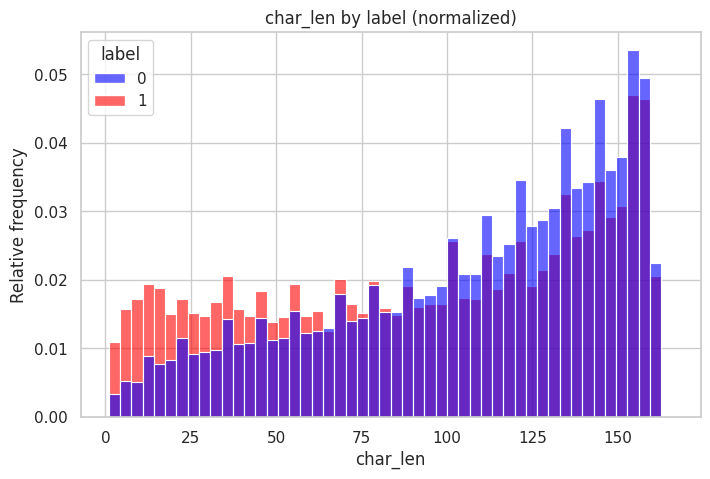

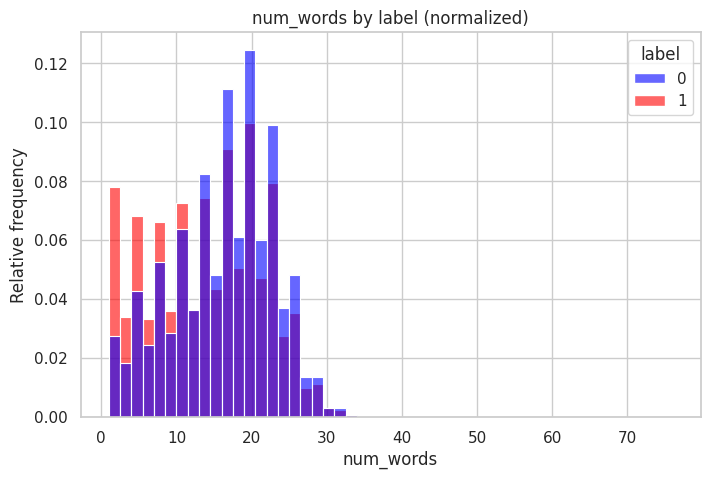

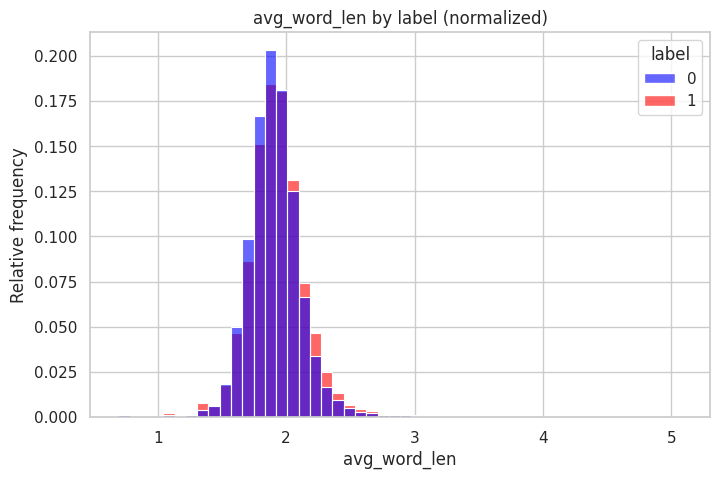

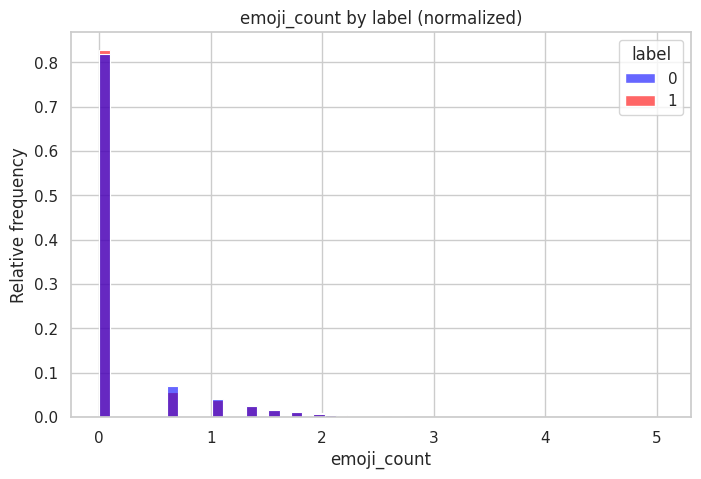

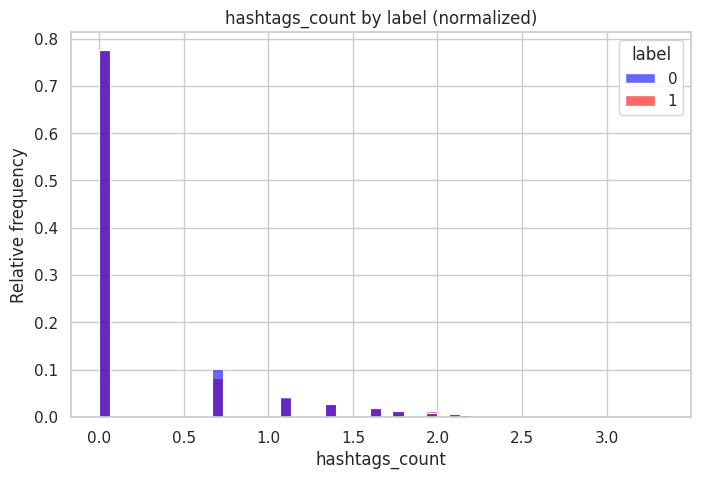

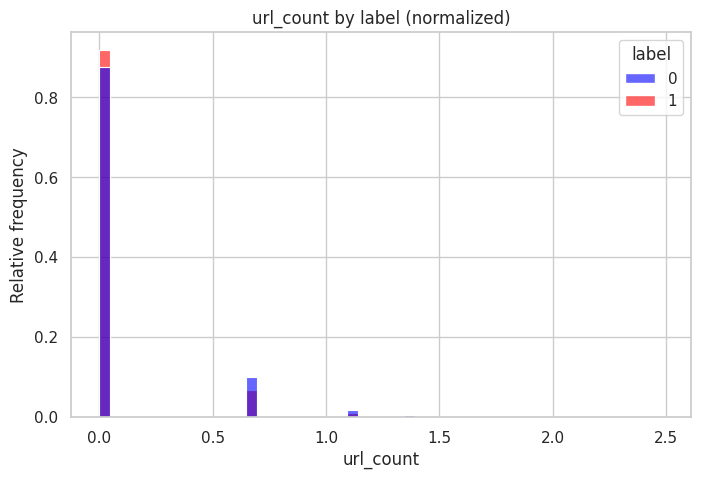

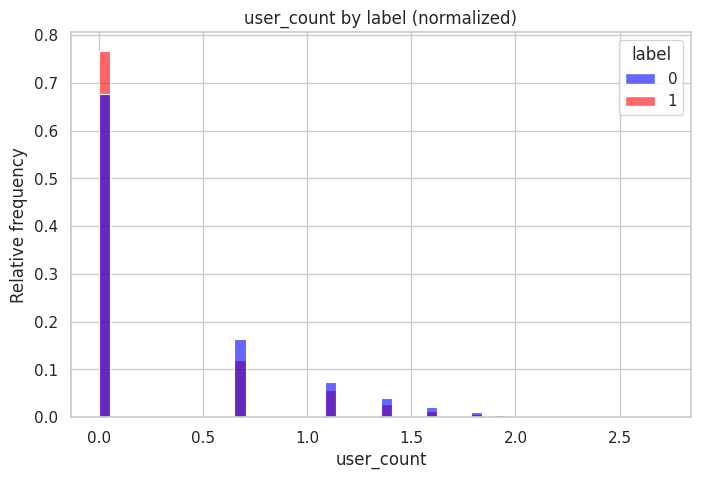

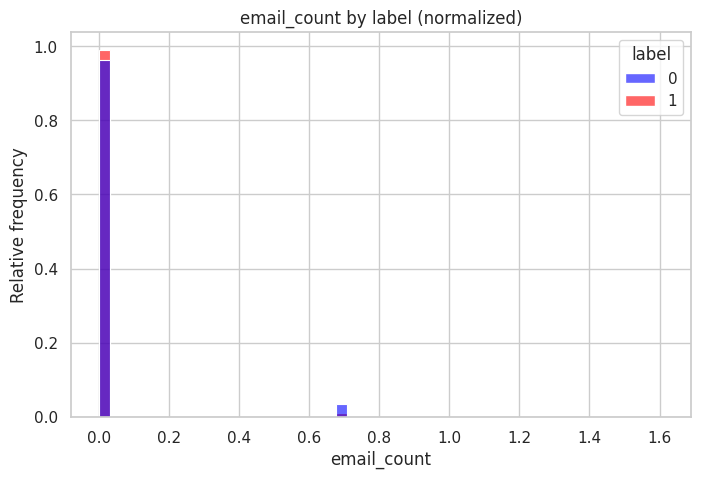

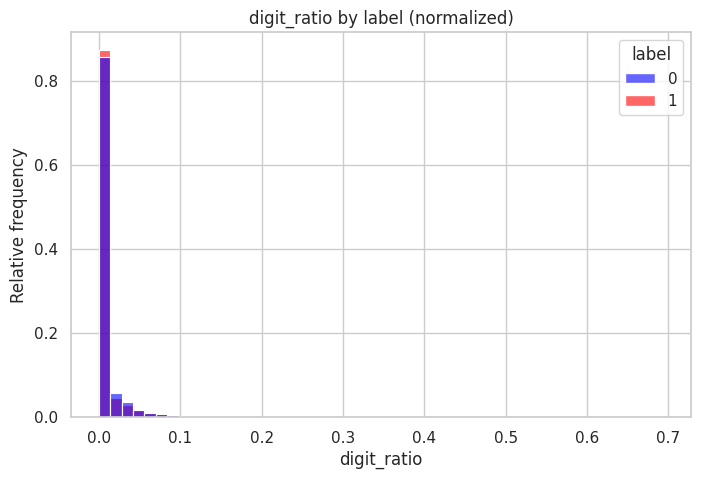

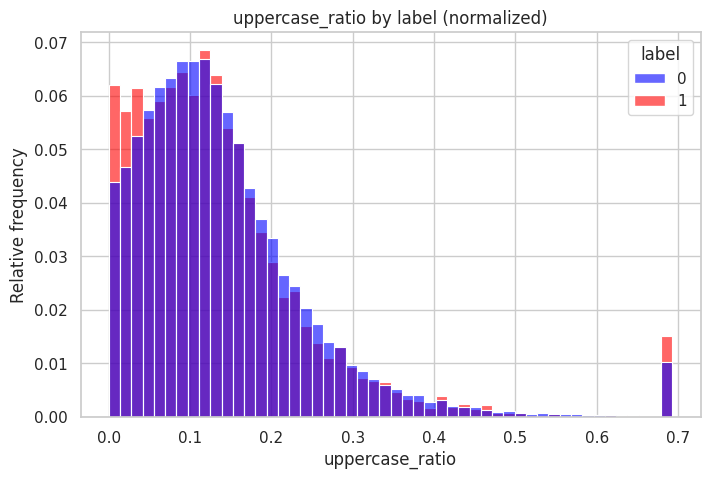

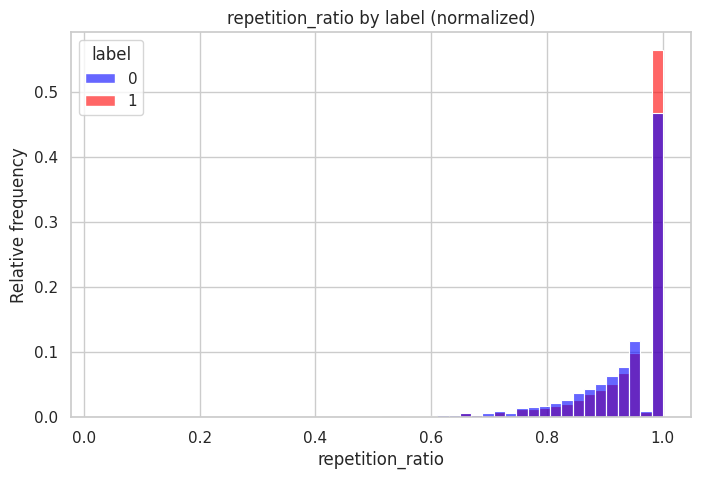

In [172]:
desc_features = X_y_train.columns[55:]

for feature in desc_features:
  plot_numeric_feature(X_y_train, feature)

In [175]:
desc_features_df_1 = X_y_train.loc[X_y_train["label"] == 0, desc_features.append(pd.Index(["description"]))]
desc_features_df_1.head()

,char_len,num_words,avg_word_len,emoji_count,hashtags_count,url_count,user_count,email_count,digit_ratio,uppercase_ratio,repetition_ratio,description
15895,75.000000,12.000000,5.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.053333,0.035714,0.916667,"Artists in conversation, since 1981. Quarterly..."
72364,155.000000,23.000000,5.782609,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.055556,0.913043,<USER> Executive Director | Universal access t...
184433,146.000000,20.000000,6.350000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.109244,1.000000,Co Founder <USER>. <USER> - Proudly working wi...
1176,152.000000,20.000000,6.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,1.000000,Estate planning attorney. Research enthusiast....
59187,150.000000,20.000000,6.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015748,0.950000,Developing materials for packaging that is des...


In [179]:
desc_features_df_1[desc_features_df_1["description"] == ""].sort_values(by="char_len").shape

(230765, 12)

In [180]:
7660/230765

0.03319394188893463